# Performative Prediction with Neural Networks: A Case Study in Strategic Classification

This notebook replicates the main experiments in the Performative Prediction with Neural Networks paper by Mehrnaz Mofakhami, Ioannis Mitliagkas, and Gauthier Gidel.

The code is based on: https://github.com/mrtzh/whynot/tree/master/examples/dynamic_decisions

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym

%matplotlib inline
import time
import seaborn as sns

## Setting up the strategic classification environment

We use the [credit simulator](https://whynot.readthedocs.io/en/latest/simulators.html#credit-simulator), which is a strategic classification simulator based on the Kaggle [*Give Me Some Credit* dataset](https://www.kaggle.com/c/GiveMeSomeCredit).

In [ ]:
env = gym.make('Credit-v0')
env.seed(1)

## Training a baseline logistic regression classifier

The state of the environment is a dataset consisting of (1) financial features of individuals, e.g. `DebtRatio`, and (2) a binary label indicating whether an individual experienced financial distress in the subsequent two years. 

In [4]:
base_dataset = env.initial_state.values()
base_features, base_labels = base_dataset["features"], base_dataset["labels"]
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")

The dataset has 18357 agents and 11 features.


Fit a logistic regression model to the data

## RRM with Resample-if-Rejected procedure 

In [5]:
import scripts.utils_torch as utils_torch
import torch
import torch.optim as optim
import copy

In [6]:
def forward(features, model):
    features_t = torch.from_numpy(features)
    with torch.no_grad():
        y_hat = model(features_t)
    return y_hat.numpy()

def accuracy(preds, epsilon, labels):
    return ((preds > (1-epsilon)/2.0)*(1.0-epsilon) == labels).mean()

### Modelling Distribution Shift

In [6]:
def agent_shift(features, mode, model = None):
    
    """Compute agent reponse to the classifier and adapt features accordingly.
    """
    
    if mode == 'default':
        
        # Move everything by epsilon in the direction towards better classification
        strategic_features = np.copy(features)
        theta_strat = config.theta[config.changeable_features].flatten()
        strategic_features[:, config.changeable_features] -= config.epsilon * theta_strat
        return strategic_features
    
    elif mode == 'case1': # W1 counterexample
        strategic_features = np.copy(features)    
        strategic_features[:,0] = (np.tanh(config.theta[0])+2) * config.epsilon
        return strategic_features
    
    elif mode == 'RS': # RIR procedure

        preds = forward(features, model)
#         print(f'preds:{preds}')
        n = features.shape[0]
        r = np.random.uniform(0,1,(n,))
        resample_indices = np.random.randint(0,n,(n,))
        new_indices = np.where(r < (preds+model.epsilon), resample_indices, np.arange(n))

        strategic_features = features[:,env.config.changeable_features]
        new_strategic_features = strategic_features[new_indices]
        new_features = np.copy(features)
        new_features[:, env.config.changeable_features] = new_strategic_features

        return new_features
        
    

### Repeated Risk Minimization

In [264]:
def tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers):
    """Run repeated risk minimization for num_iters steps"""
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.config.mode = mode

    # Track loss and accuracy before/after updating model on new distribution
    loss_start, loss_end, acc_start, acc_end, theta_gaps, f_theta_gaps = [], [], [], [], [], []
    
    if layers==1:
        model = utils_torch.onelayer_NN(epsilon, mode)
    else:
        model = utils_torch.twolayers_NN(epsilon, mode)
        
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.Adam(model.parameters(), lr=3e-4)
#     optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)
    
    base_dataset = env.initial_state.values()
    base_features, base_labels = base_dataset["features"], base_dataset["labels"]
    base_labels = base_labels.astype('float64')
    base_labels[base_labels==1]=1.0-epsilon

    base_features_t = torch.from_numpy(base_features)
    base_labels_t = torch.from_numpy(base_labels)


    eval_bool = False
    utils_torch.fit_logistic_regression(base_features_t, base_labels_t, l2_penalty, model, optimizer, eval_bool, mode = mode)
    
    preds = forward(base_features, model)
    base_acc = accuracy(preds, epsilon, base_labels)
    print(f'BASE ACCURACY:{base_acc}')
    
    M = 0.0
    
    labels = np.copy(base_labels)
    
    for step in range(num_iters):
        

        # Deploy classifier and observe strategic response
        ''' From the first step strategic behavior is applied so it differs for different values of epsilon '''
          
        features_strat = agent_shift(base_features, mode, model)

        # Evaluate loss and accuracy on the new distribution
        features_strat_t = torch.from_numpy(features_strat)
        labels_t = torch.from_numpy(labels)

        eval_bool = True
        loss_start.append(
            utils_torch.evaluate_logistic_loss(features_strat_t, labels_t, l2_penalty, model, eval_bool, mode = mode).item())
        eval_bool = False
        
        preds = forward(features_strat, model)
#         preds = forward(features_strat, model)
        theta_list = []
        with torch.no_grad():
            for weight in model.parameters():
                theta_list.append(weight.detach().clone().numpy())
                
        start_acc = accuracy(preds, epsilon, labels)
        acc_start.append(start_acc)
        print(f'start_accuracy:{start_acc}')


        M = np.maximum(M, np.max(np.abs(preds - labels)))
        
        # Learn a new model on the induced distribution
        utils_torch.fit_logistic_regression(features_strat_t, labels_t, l2_penalty, model, optimizer, eval_bool, mode = mode)
        
        # Evaluate loss and accuracy on the strategic distribution after training
        eval_bool = True
        loss_end.append(
            utils_torch.evaluate_logistic_loss(features_strat_t, labels_t, l2_penalty, model, eval_bool, mode = mode).item()
        )
        eval_bool = False
        
        predss = forward(features_strat, model)
        end_acc = accuracy(predss, epsilon, labels)

        print()
        print(f'end_accuracy:{end_acc}')
        print()
        acc_end.append(end_acc)
        
        theta_new_list = []
        with torch.no_grad():
            for weight in model.parameters():
                theta_new_list.append(weight.detach().clone().numpy())
          
        theta_gap = 0
        for i in range(len(theta_list)):
            theta_gap += np.linalg.norm(theta_list[i]-theta_new_list[i])
            
            
        theta_gaps.append(theta_gap)
            

        # Track distance between iterates
          
        f_theta_gap = np.sqrt(np.mean((preds - predss)**2))
        f_theta_gaps.append(f_theta_gap)

    return loss_start, loss_end, acc_start, acc_end, theta_gaps, f_theta_gaps

### Training

In [ ]:
delta_list = [0.1, 0.4, 0.7, 0.9]
num_iters = 30
mode = 'RS' # Resample-if-Rejected
layers = 2
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]

loss_starts, acc_starts, loss_ends, acc_ends, theta_gaps, f_gaps = [], [], [], [], [], []
start_time = time.time()
for epsilon_idx, epsilon in enumerate(delta_list):
    print(f"Running retraining for epsilon {epsilon:.2f}")
    learning_rate = learning_rates[epsilon_idx]
    loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers)
    loss_starts.append(loss_start)
    loss_ends.append(loss_end)
    acc_starts.append(acc_start)
    acc_ends.append(acc_end)
    theta_gaps.append(theta_gap)
    f_gaps.append(f_theta_gaps)
total_time = time.time() - start_time

In [68]:
print(f"total time:{total_time}")

total time:342.94967889785767


### Visualizing the loss

#### Execute this cell if you have run the training for a single value of $\delta$; it will plot the evolution of Log Performative Risk and Accuracy through iterations of RRM for the specified $\delta$.

In [ ]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
idx = 0
ax = axes[0]
offset = 0.6
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

ax.set_title("Log Performative Risk", fontsize=26)


for i in range( 0, num_iters):
    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
    if i < num_iters - 1:
        ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')

ax.set_xlabel("Iteration", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.tick_params(axis='both', labelsize=14)
plt.rcParams['ytick.labelsize']=14

acc_starts_np = np.array(acc_starts) * 100
acc_ends_np = np.array(acc_ends) * 100

minimum = 100
maximum = 0
ax = axes[1]
offset = 0.6
ax.set_title("Accuracy", fontsize=26)
for i in range(0, num_iters):
    ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-')
    if i < num_iters - 1:
        ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')

    minimum = min(minimum, acc_starts_np[idx][i])
    minimum = min(minimum, acc_ends_np[idx][i])
    maximum = max(maximum, acc_starts_np[idx][i])
    maximum = max(maximum, acc_ends_np[idx][i])

ax.set_xlabel("Iteration", fontsize=22)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.tick_params(axis='both', labelsize=14)


ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim([minimum-0.1, maximum+0.1])
plt.subplots_adjust(hspace=0.25)

# fig.savefig('./Results/Run2/result.png', dpi=300)

In [3]:
import sys
sys.path.append("/Users/mehrnaz/Documents/uni(backup-28-12-2022) 2/Mila/Research Readings/AISTATS submission/Camera-ready/Code/Performative-Prediction-with-Neural-Networks/scripts")
import seaborn as sns
from utils_plot import configure_plt

### Plot loss function for different values of delta

In [ ]:
delta_list = [0.1 , 0.4, 0.7, 0.9]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

for idx, epsilon in enumerate(delta_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
#     print(len(loss_starts[idx]))
#     print(num_iters)
    for i in range( 0, num_iters):
        if i==0:
            ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
        else: 
            ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')

        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='both', labelsize=14)
        plt.rcParams['ytick.labelsize']=14
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    if idx%2 == 0 :
        ax.set_ylabel("Log Performative Risk", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)
        
plt.subplots_adjust(hspace=0.25)
# fig.savefig('./Results/Run14/loss_different_delta.png', dpi=300)

### Plot accuracy for different values of delta

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))


for idx, epsilon in enumerate(delta_list):
#     acc_starts_np = np.array(acc_starts) * 100
#     acc_ends_np = np.array(acc_ends) * 100

    minimum = 100
    maximum = 0
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
    acc_starts = acc_starts_c[k]
    acc_ends = acc_ends_c[k]
    acc_starts_np = np.array(acc_starts) * 100
    acc_ends_np = np.array(acc_ends) * 100

    for i in range(0, num_iters):
        if i==0:
            ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-', label='h=8')
        else:
            ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-')

        if i < num_iters - 1:
            ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')
                    
            
    ax.legend()
    minimum = min(minimum, acc_starts_np[idx][i])
    minimum = min(minimum, acc_ends_np[idx][i])
    maximum = max(maximum, acc_starts_np[idx][i])
    maximum = max(maximum, acc_ends_np[idx][i])

    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='both', labelsize=14)
    plt.rcParams['ytick.labelsize']=14
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    if idx%2 == 0 :
        ax.set_ylabel("Accuracy", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylim([minimum-2, maximum+0.2])
    plt.subplots_adjust(hspace=0.25)

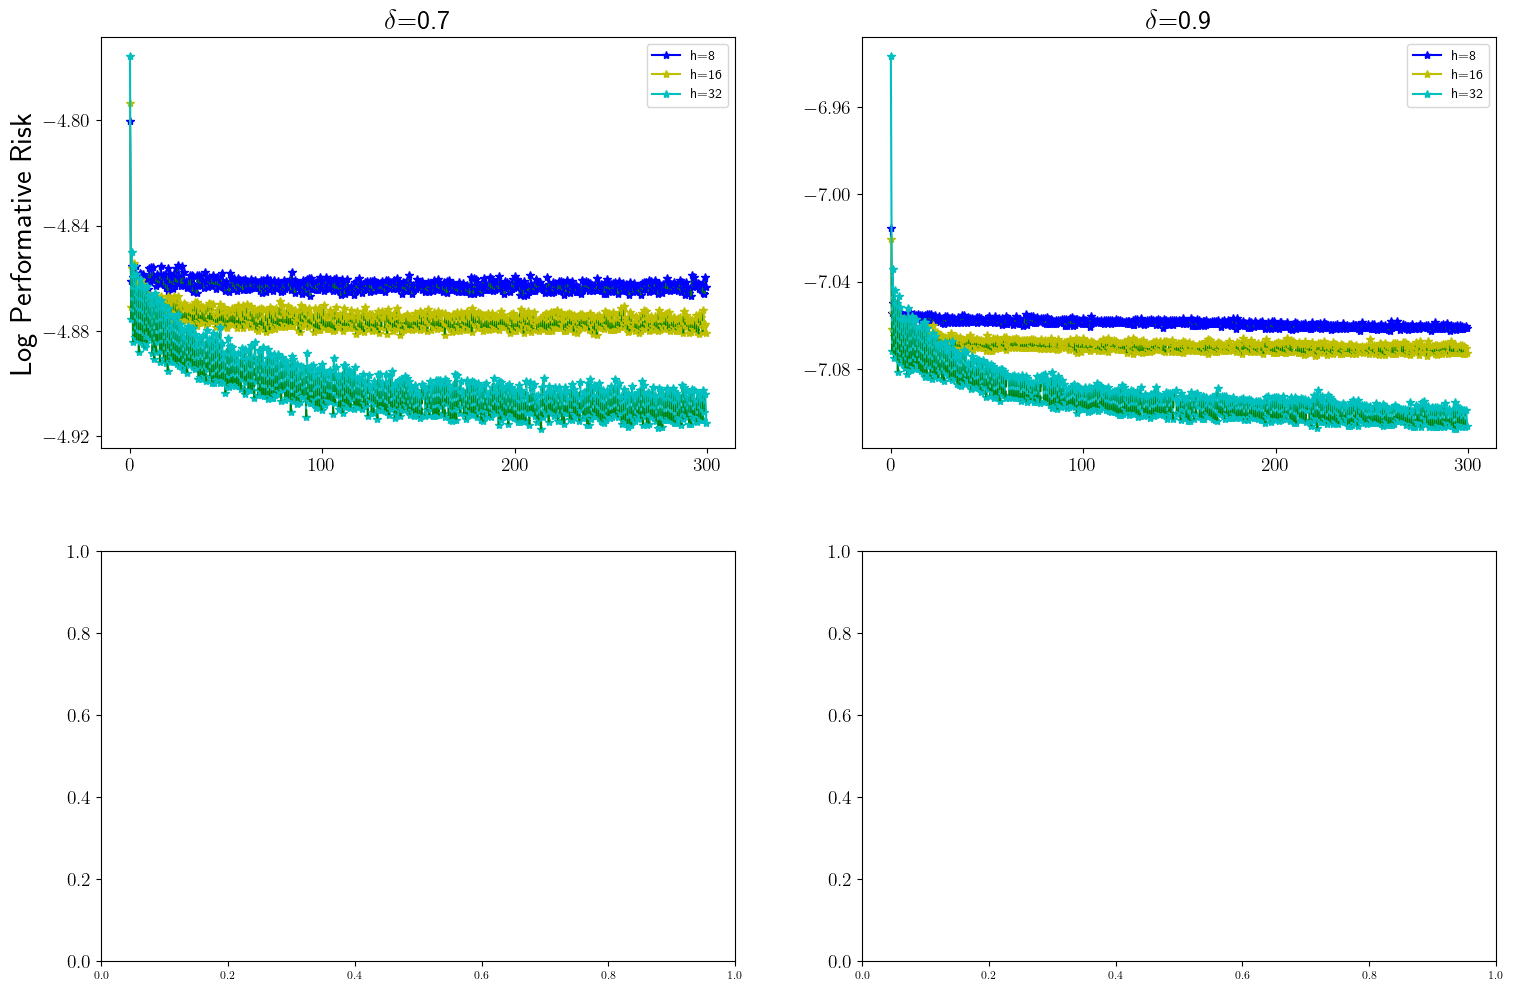

In [12]:
delta_list = [0.7, 0.9]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

    
for idx, epsilon in enumerate(delta_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
#     print(len(loss_starts[idx]))
#     print(num_iters)
    num_iters=300
    for k in range(3):
        loss_starts=loss_starts_c[k]
        loss_ends=loss_ends_c[k]
        loss_starts_log = np.log(np.array(loss_starts))
        loss_ends_log = np.log(np.array(loss_ends))
        if k==0:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-', label='h=8')
                else: 
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
                    
                if i < num_iters - 1:
                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        elif k==1:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'y*-', label='h=16')
                else:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'y*-')

                if i < num_iters - 1:
                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                    
        elif k==2:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'c*-', label='h=32')
                else:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'c*-')

                if i < num_iters - 1:

                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                    
        elif k==3:
            for i in range( 0, num_iters):
                if i==0:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'c*-', label='h=64')
                else:
                    ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'c*-')

                if i < num_iters - 1:

                    ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='both', labelsize=14)
        plt.rcParams['ytick.labelsize']=14
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.legend()


    if idx%2 == 0 :
        ax.set_ylabel("Log Performative Risk", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)
        
plt.subplots_adjust(hspace=0.25)
fig.savefig('./Results/HiddenLayers/different_hiddens.png', dpi=600)

### Save the results

In [266]:
import pickle

dir_name = 'Run2'

file_name = "./Results/"+dir_name+"/f_gaps.pkl"
with open("./Results/"+dir_name+"/f_gaps.pkl", 'wb') as f:
    pickle.dump(f_gaps, f)
    
with open("./Results/"+dir_name+"/theta_gaps.pkl", 'wb') as f:
    pickle.dump(theta_gaps, f)
    
with open("./Results/"+dir_name+"/loss_starts.pkl", 'wb') as f:
    pickle.dump(loss_starts, f)
    
with open("./Results/"+dir_name+"/loss_ends.pkl", 'wb') as f:
    pickle.dump(loss_ends, f)
    
with open("./Results/"+dir_name+"/acc_starts.pkl", 'wb') as f:
    pickle.dump(acc_starts, f)
    
with open("./Results/"+dir_name+"/acc_ends.pkl", 'wb') as f:
    pickle.dump(acc_ends, f)